# CNN-based Blood Cell Classification
In this section, we read datas and split to train data and validations data.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = "../dataset"
batch_size = 32
image_size = (300,300)

train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split = 0.2,
    subset = "training",
    seed = 44
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split = 0.2,
    subset = "validation",
    seed = 44
)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


#### Optimizing Dataset

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Data Preparation and Augmentation
Rescaled images for normalization and used data augmentation techniques.

In [4]:
FILL_MODE = "nearest"

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1,fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.1,fill_mode=FILL_MODE)
])

## Model Architecture
Build the CNN model using convolutional layers, batch normalization, dropout, and other components.
Utilize the Functional API for flexible and readable model design.

In [5]:
def conv_block(x, filters, use_bn=False):
    x = layers.Conv2D(filters, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return x

In [6]:
inputs = tf.keras.Input(shape=(300,300,3))

x = data_augmentation(inputs)

#CNN Layers
x = conv_block(x,32,True)
x = conv_block(x,64,False)
x = conv_block(x,64,False)
x = conv_block(x,128,True)

#DNN Layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

#Output Layer
outputs = layers.Dense(5,activation="softmax")(x)

model = tf.keras.Model(inputs=inputs,outputs=outputs)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 298, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 33, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,520,965 (32.50 MB)

 Trainable params: 8,520,645 (32.50 MB)

 Non-trainable params: 320 (1.25 KB)

In [8]:
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ["accuracy"]
)

In [10]:
#CallBacks

#Callback for reducing learning rate
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',          
    factor=0.5,                  
    patience=3,                  
    verbose=1                    
)

#Callback for early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',              
    patience=4,                      
    restore_best_weights=True       
)

In [11]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 15,
    callbacks = [lr_scheduler,early_stop]
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 826ms/step - accuracy: 0.6257 - loss: 2.3792 - val_accuracy: 0.1840 - val_loss: 34.4374 - learning_rate: 0.0010
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 845ms/step - accuracy: 0.8553 - loss: 0.6208 - val_accuracy: 0.1850 - val_loss: 41.8346 - learning_rate: 0.0010
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 830ms/step - accuracy: 0.9079 - loss: 0.6094 - val_accuracy: 0.2210 - val_loss: 15.5950 - learning_rate: 0.0010
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 843ms/step - accuracy: 0.9230 - loss: 0.4533 - val_accuracy: 0.7990 - val_loss: 0.8434 - learning_rate: 0.0010
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 836ms/step - accuracy: 0.9305 - loss: 0.4268 - val_accuracy: 0.7430 - val_loss: 1.8199 - learning_rate: 0.0010
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 845ms/step - accuracy: 0.9408 - loss: 0.3701 - val_accuracy: 0.6660 - val_loss: 2.2952 - learning_rate: 0.0010
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accur

## Visualization of Training Results
Plot training and validation accuracy and loss over epochs to assess learning progress.

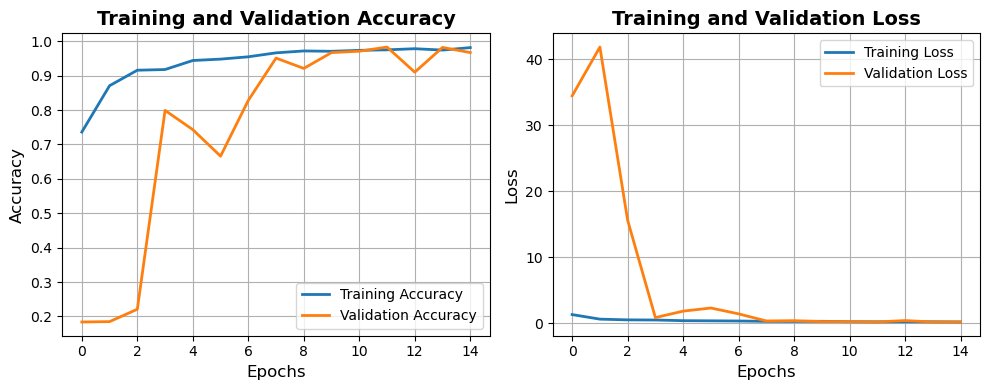

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy", linewidth=2)
plt.plot(val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Accuracy",fontsize=12)
plt.legend()
plt.title("Training and Validation Accuracy",fontsize=14,fontweight='bold')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(loss, label="Training Loss",linewidth=2)
plt.plot(val_loss, label="Validation Loss",linewidth=2)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.legend()
plt.title("Training and Validation Loss",fontsize=14,fontweight='bold')
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs,axis=1)

y_true = np.concatenate([y for x, y in val_data], axis=0)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step


2025-07-31 02:21:12.315064: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Performance Evaluation
Evaluate the trained model on the test dataset using F1-score and Confusion Matrix

In [14]:
class_names = os.listdir(data_dir)
report_text = classification_report(y_true, y_pred, target_names=class_names)
print("```\n" + report_text + "\n```")

```
                precision    recall  f1-score   support

      basophil       0.98      1.00      0.99       231
      monocyte       0.95      0.99      0.97       184
  erythroblast       1.00      0.94      0.97       189
seg_neutrophil       0.99      1.00      0.99       209
    myeloblast       0.99      0.99      0.99       187

      accuracy                           0.98      1000
     macro avg       0.98      0.98      0.98      1000
  weighted avg       0.98      0.98      0.98      1000

```


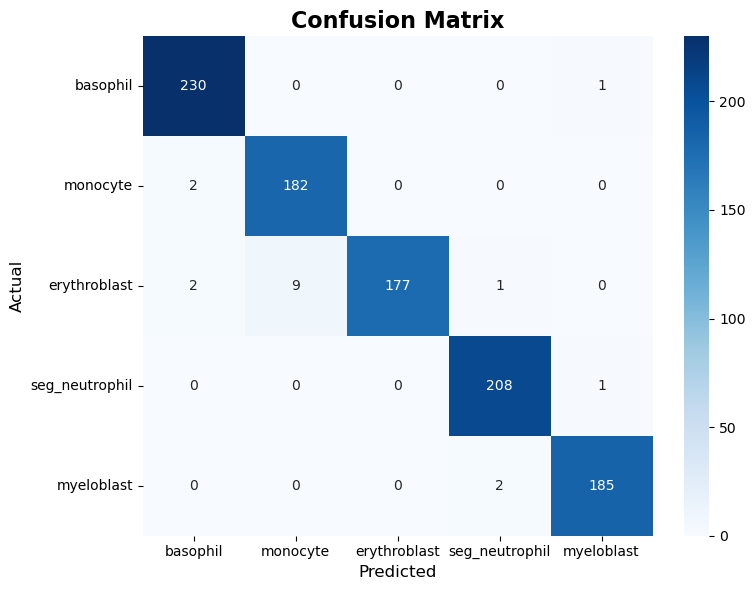

In [15]:
cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)
plt.title("Confusion Matrix",fontsize=16,fontweight="bold")
plt.tight_layout()
plt.show()

In [16]:
#Saving model
model.save("../models/cell_classifier_cnn_model.keras")